In [5]:
import kagglehub
import os
import logging
from typing import Union, List, Dict, Any
logging.basicConfig(level=logging.INFO)

In [ ]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [ ]:
# Predict Online Gaming Behavior Dataset
# https://www.kaggle.com/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset

import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/predict-online-gaming-behavior-dataset")

print("Path to dataset files:", path)

# List the contents of the downloaded directory
#print(os.listdir(path))

Path to dataset files: /Users/aurora/.cache/kagglehub/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset/versions/1


In [8]:
file_name = os.listdir(path)[0]
full_file_path = os.path.join(path, file_name)
full_file_path

'/Users/aurora/.cache/kagglehub/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset/versions/1/online_gaming_behavior_dataset.csv'

In [ ]:
### EDA Util funtions ###

def load_data(file_path: str):
    try:
        df = pd.read_csv(f"{file_path}")
        logging.info("File successfully loaded")
        return df
    
    except Exception as e:
        logging.error(f"Error loading file: {e}")
        return None

def log_transform_data(data:pd.DataFrame, columns:List[str], remove_columns:List[str])->pd.DataFrame:
    columns_to_transform = [col for col in columns if columns not in remove_columns]
    log_data = np.log10(data[columns_to_transform]+1)
    log_data.columns = [f'log_{col}' for col in columns]
    
    return log_data

# Plot kde distribution by target
    
def kde_viz_plots(data:pd.DataFrame, columns:List, hue:str='EngagementLevel', cols_to_remove:List[str] = None, common_norm:bool=False):
    if cols_to_remove:
        # Create the final list of columns to plot
        cols_to_plot = [col for col in columns if col not in cols_to_remove]
    else:
        cols_to_plot = columns
    
    n_cols = len(cols_to_plot)
    
    if n_cols == 0:
        print("No columns remaining to plot.")
        return

    fig_height = max(5, n_cols * 3) # Calculate height based on actual plots
    fig, axes = plt.subplots(n_cols, 1, figsize=(15, fig_height))
    
    # Handle the case where only one plot is created (axes is not an array)
    if n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        sns.kdeplot(data=data, x=col, fill=True, ax=axes[i], hue=hue, common_norm=common_norm)
    
    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.show()

# what is the distribution of the features given the target column categories?

def viz_cat_interaction(data, columns: List[str], target_col:str = 'EngagementLevel'):
    fig_row = len(columns)
    fig,axes = plt.subplots(fig_row, 1, figsize=(8,fig_row*4))
    axes = axes.flatten()

    for i,col in enumerate(columns):
        proportions_df = pd.crosstab(index=data[target_col], columns=data[col], normalize='index').round(4) * 100
        proportions_df.plot(kind='bar', stacked=False, ax=axes[i], rot=0)
    plt.tight_layout()
    plt.show()


# what is the distribution of the target, given the feature column categories?

def vizualize_categorical_interaction(data:pd.DataFrame, feature_cols:List[str], target_col:str = 'EngagementLevel'):
    fig_row = len(feature_cols)
    fig, axes = plt.subplots(fig_row,1, figsize=(8,15))
    axes = axes.flatten()
    
    for i,col in enumerate(feature_cols):
        proportions_df = pd.crosstab(index=data[col], columns=data[target_col], normalize='index')
        proportions_df.plot(kind='bar', stacked=False, ax=axes[i])

    plt.tight_layout()
    plt.show()

def heatmap(data:pd.DataFrame, columns:List[str], target_col:str = 'EngagementLevel'):
    combined_proportions = []
    for col in columns:
        proportions = pd.crosstab(index=data[col], columns=data[target_col], normalize='index').round(3) * 100
        proportions.rename(columns={
            'High':f'{col}_High',
            'Low':f'{col}_Low',
            'Medium':f'{col}_Medium'
        }, inplace=True)
        combined_proportions.append(proportions)
    
    final_df = pd.concat(combined_proportions, axis=0)
    #return final_df
    plt.figure(figsize=(len(columns) * 2, len(final_df) * 0.4))
    sns.heatmap(final_df, annot=True, fmt=".2f", )
    plt.show()  

# Get skewed columns above threshold for log transformation

def skewness_analysis(data:pd.DataFrame, target_col: str = 'EngagementLevel')->pd.DataFrame:
    numerical_cols = data.select_dtypes(include=np.number).columns
    numerical_cols = numerical_cols.drop(target_col, errors='ignore')

    # Calculate skewness for each numerical column
    skew_values = data[numerical_cols].apply(lambda x: skew(x.dropna()))

    # Convert the results to a DataFrame for easy viewing
    skewness_df = pd.DataFrame({
        'Feature': skew_values.index,
        'Skewness': skew_values.values.round(4)
    })

    return skewness_df

def categorical_to_ordinal(series:pd.Series, values_from:List[Any]):
    """Converts a categorical series to ordinal"""
    map_dict = {}
    for i,value in enumerate(values_from):
        map_dict[value] = i

    return series.map(map_dict, None)
    
    

In [10]:
df = load_data(file_path=full_file_path)
df.info()

INFO:root:File successfully loaded


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [11]:
categorical_columns = df.select_dtypes(include=["object", "category"]).columns.to_list()
numerical_columns =  df.select_dtypes(include=[int, float]).columns.to_list()

In [12]:
df[categorical_columns].head()

,Gender,Location,GameGenre,GameDifficulty,EngagementLevel
0,Male,Other,Strategy,Medium,Medium
1,Female,USA,Strategy,Medium,Medium
2,Female,USA,Sports,Easy,High
3,Male,USA,Action,Easy,Medium
4,Male,Europe,Action,Medium,Medium


In [13]:
df[numerical_columns].head()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
0,9000,43,16.271119,0,6,108,79,25
1,9001,29,5.525961,0,5,144,11,10
2,9002,22,8.223755,0,16,142,35,41
3,9003,35,5.265351,1,9,85,57,47
4,9004,33,15.531945,0,2,131,95,37


In [15]:
print(f"Unique PlayerID: {df['PlayerID'].nunique()}")

Unique PlayerID: 40034


In [16]:
for col in categorical_columns:
    print(f"Column Name: {col}")
    print(df[col].value_counts())
    print('--------------------')

Column Name: Gender
Gender
Male      23959
Female    16075
Name: count, dtype: int64
--------------------
Column Name: Location
Location
USA       16000
Europe    12004
Asia       8095
Other      3935
Name: count, dtype: int64
--------------------
Column Name: GameGenre
GameGenre
Sports        8048
Action        8039
Strategy      8012
Simulation    7983
RPG           7952
Name: count, dtype: int64
--------------------
Column Name: GameDifficulty
GameDifficulty
Easy      20015
Medium    12011
Hard       8008
Name: count, dtype: int64
--------------------
Column Name: EngagementLevel
EngagementLevel
Medium    19374
High      10336
Low       10324
Name: count, dtype: int64
--------------------


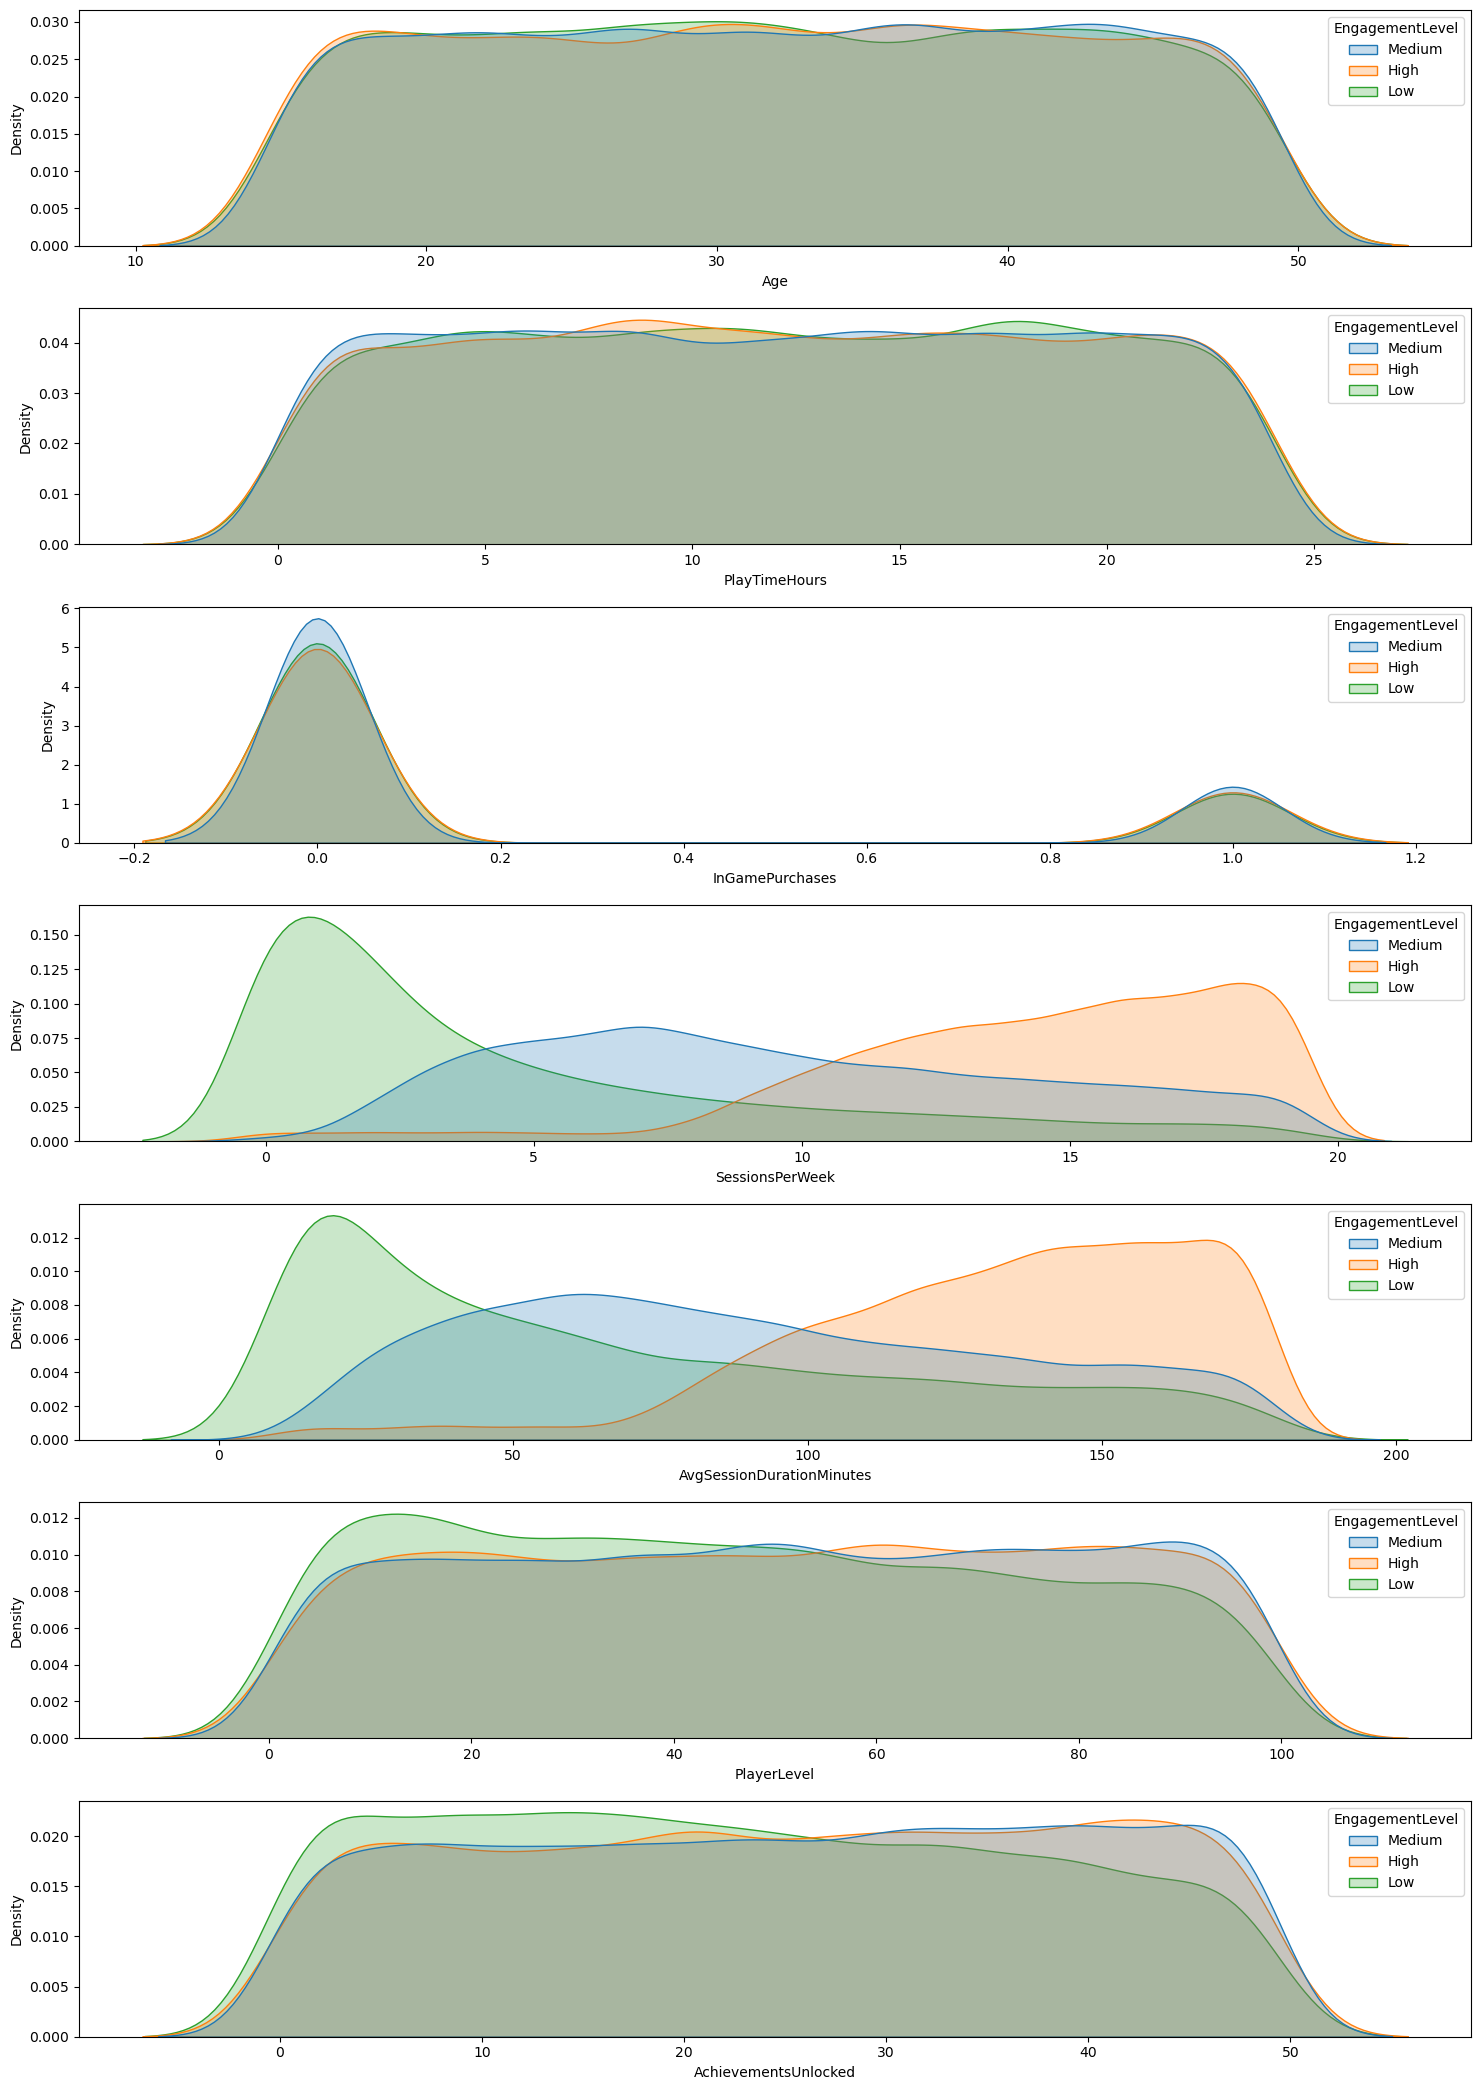

In [46]:
kde_viz_plots(data=df, columns=numerical_columns, hue='EngagementLevel', cols_to_remove=['EngagementLevel', 'PlayerID'])

In [ ]:
# SessionsPerWeek and AvgSessionDurationMinutes are highly correlated to EngagemetLevel. 
# Depending on when EngagementLevel is assigned, these two features may leak information about the target which would be cause for removal.

<Axes: >

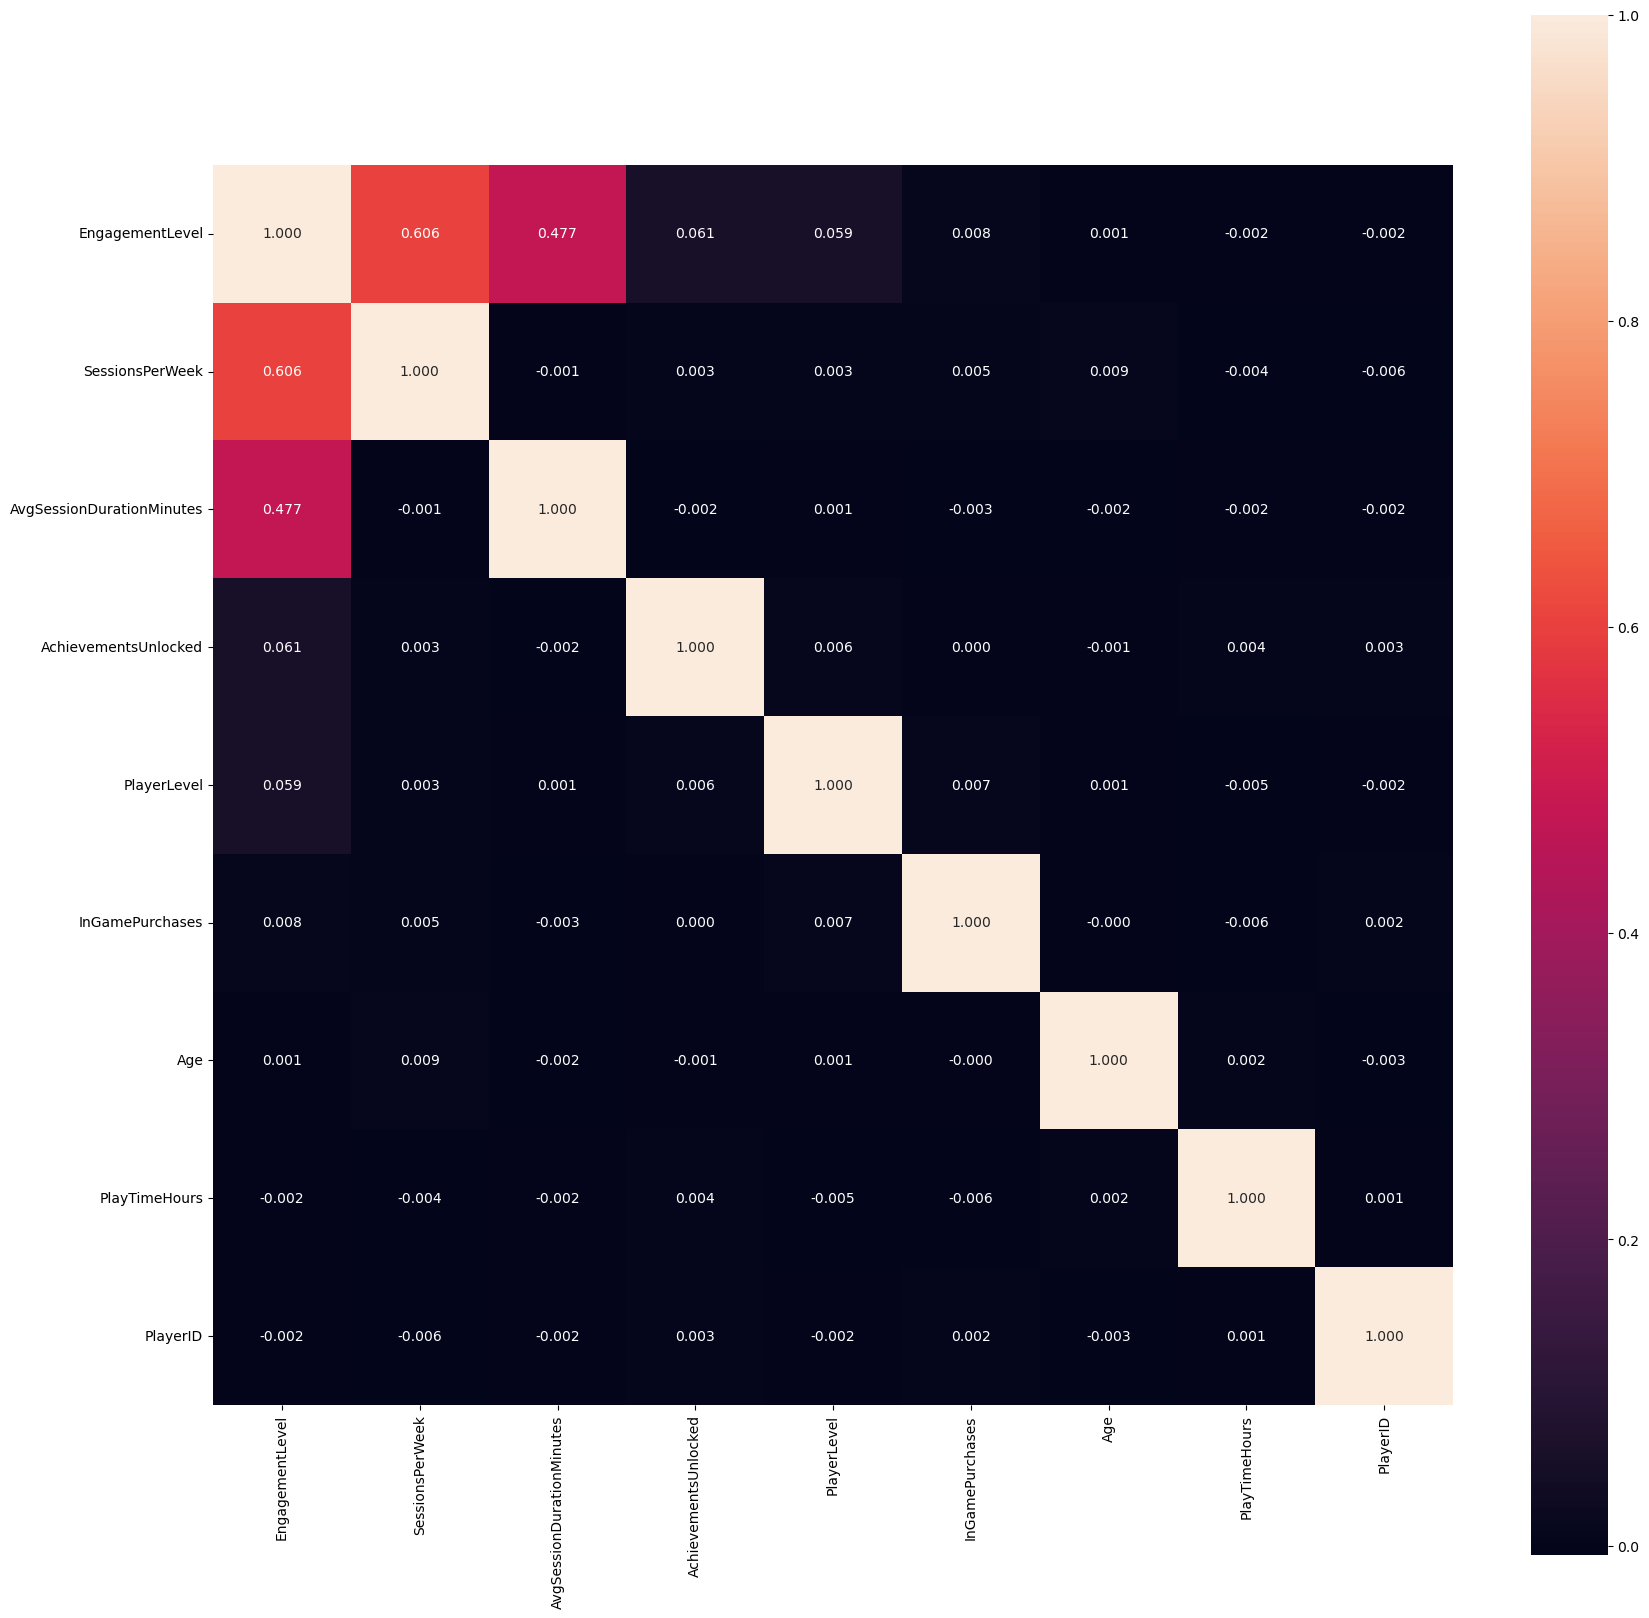

In [ ]:
# correlations

corr_df = df[numerical_columns]
corr_df['EngagementLevel'] = categorical_to_ordinal(df['EngagementLevel'], values_from=['Low', 'Medium', 'High'])

corrmat = corr_df.corr()
k = len(corr_df.columns)
cols = corrmat.nlargest(k, 'EngagementLevel')['EngagementLevel'].index
cm = np.corrcoef(corr_df[cols].values.T)

f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm,cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [28]:
skewness_df = skewness_analysis(df)

# Filter for columns that are highly right-skewed (positive skew)
# A common threshold for 'high skew' is a value > 1.0 or > 0.8

right_skewed_cols = skewness_df[skewness_df['Skewness'] > 0.7].sort_values(
    by='Skewness', ascending=False
)

# Display the columns
print("Highly Right-Skewed Columns (Candidates for Log Transformation):")
print(right_skewed_cols)

Highly Right-Skewed Columns (Candidates for Log Transformation):
           Feature  Skewness
3  InGamePurchases    1.4933


In [29]:
df[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
PlayerID,40034.0,29016.500000,11556.964675,9000.000000,19008.250000,29016.500000,39024.750000,49033.000000
Age,40034.0,31.992531,10.043227,15.000000,23.000000,32.000000,41.000000,49.000000
PlayTimeHours,40034.0,12.024365,6.914638,0.000115,6.067501,12.008002,17.963831,23.999592
InGamePurchases,40034.0,0.200854,0.400644,0.000000,0.000000,0.000000,0.000000,1.000000
SessionsPerWeek,40034.0,9.471774,5.763667,0.000000,4.000000,9.000000,14.000000,19.000000
AvgSessionDurationMinutes,40034.0,94.792252,49.011375,10.000000,52.000000,95.000000,137.000000,179.000000
PlayerLevel,40034.0,49.655568,28.588379,1.000000,25.000000,49.000000,74.000000,99.000000
AchievementsUnlocked,40034.0,24.526477,14.430726,0.000000,12.000000,25.000000,37.000000,49.000000


In [30]:
df_log_tsfrm = log_transform_data(data=df, columns=right_skewed_cols.Feature.to_list(), remove_columns=['EngagementLevel'])
df_log_tsfrm['EngagementLevel'] = df['EngagementLevel']

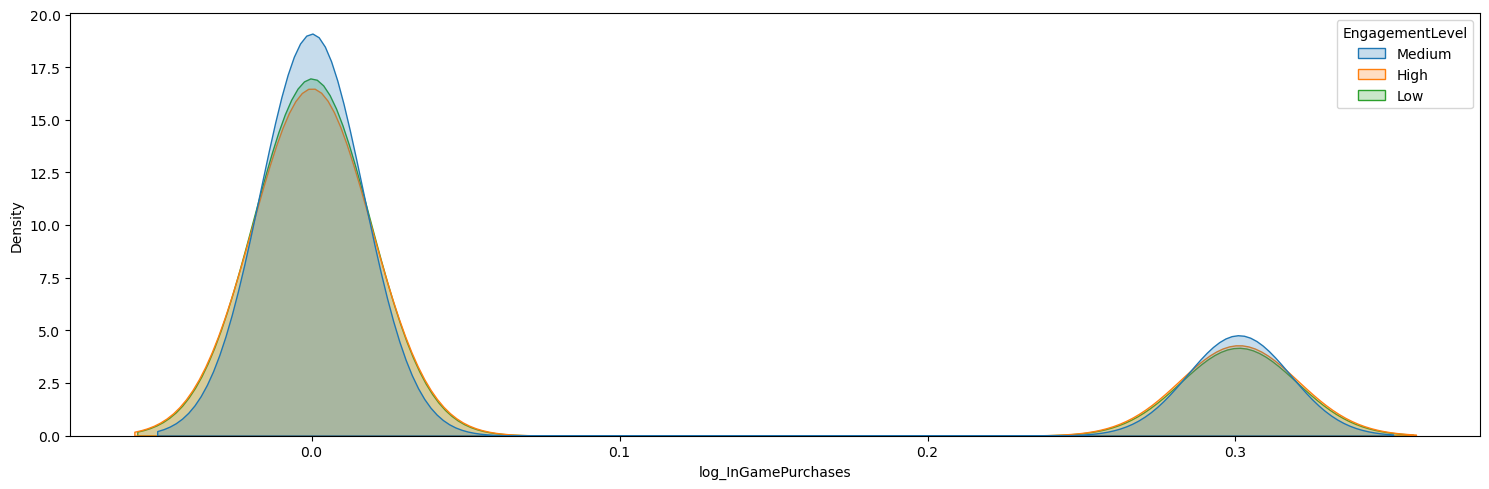

In [47]:
kde_viz_plots(df_log_tsfrm, columns=df_log_tsfrm.columns, common_norm=False, hue='EngagementLevel', cols_to_remove=['EngagementLevel'])

['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']


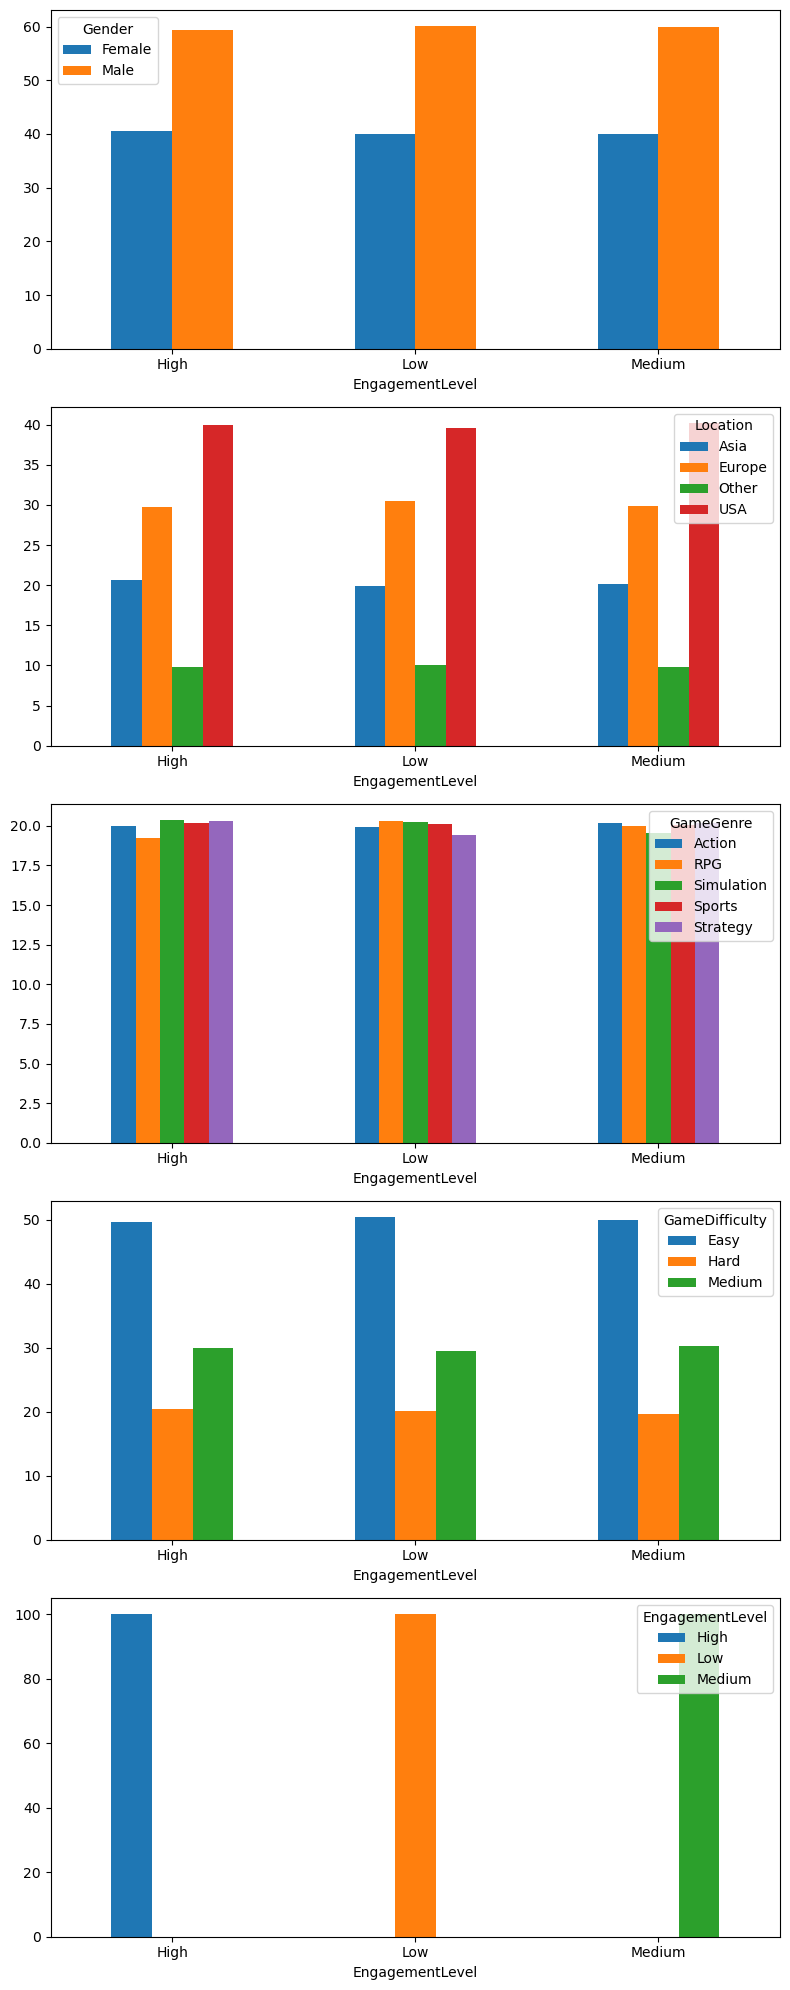

In [18]:
print(categorical_columns)
viz_cat_interaction(df, columns=categorical_columns)

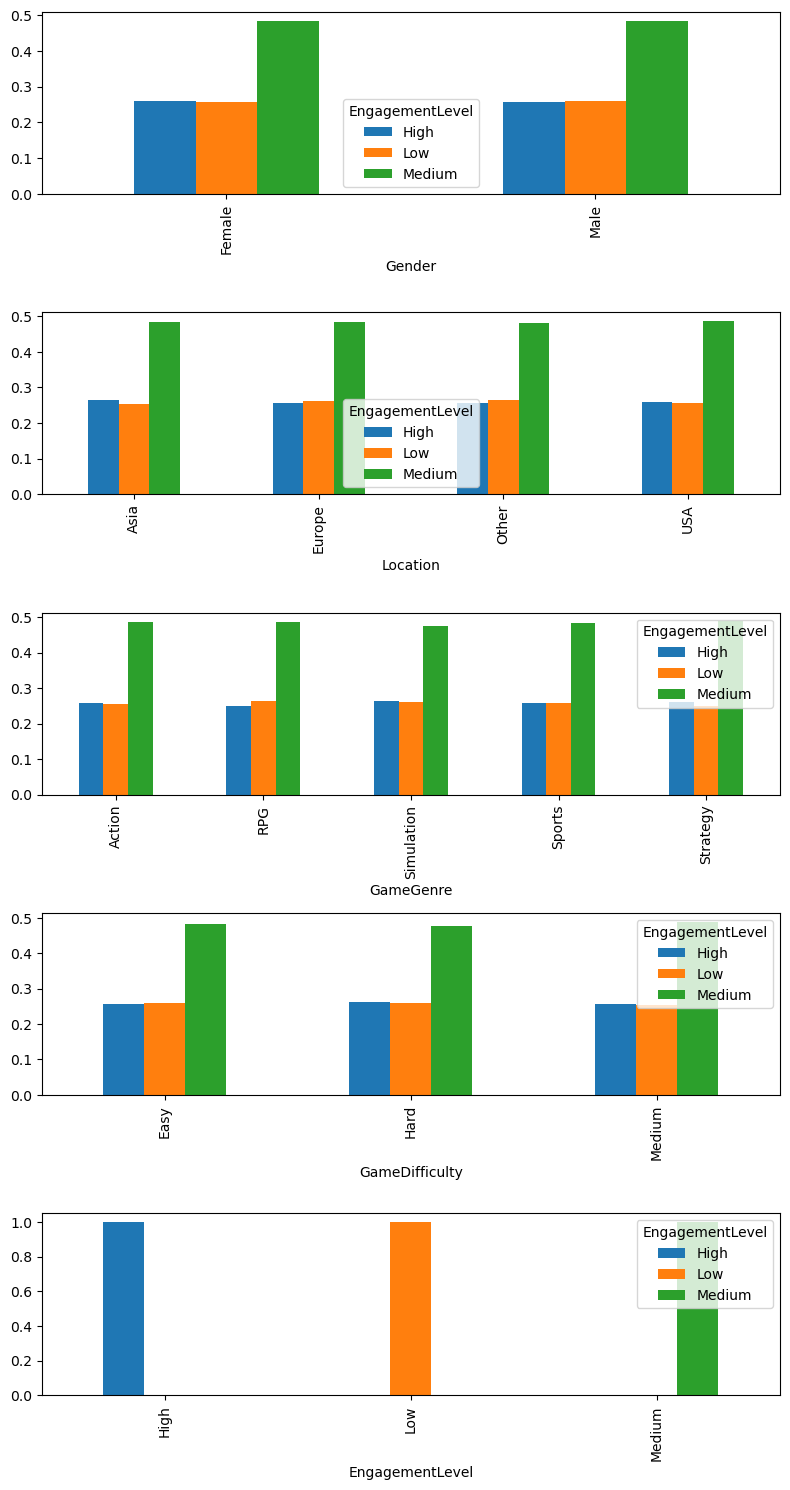

In [ ]:
vizualize_categorical_interaction(df, feature_cols=categorical_columns)

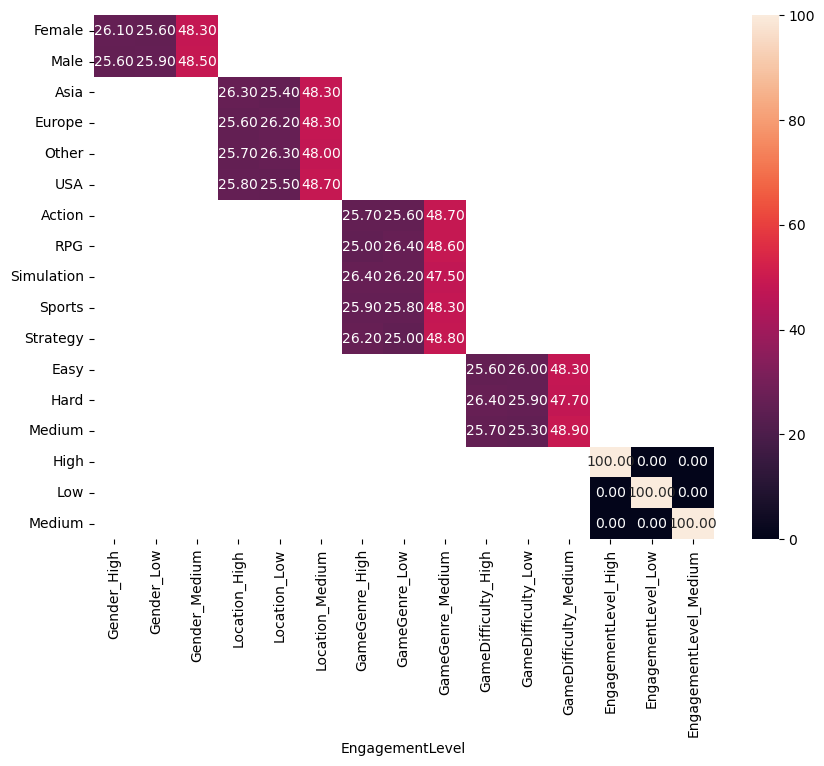

In [24]:
heatmap(df, categorical_columns)

In [130]:
## Util Functions START ##

def categorical_to_ordinal(series:pd.Series, values_from:List[Any]):
    """Converts a categorical series to ordinal"""
    map_dict = {}
    for i,value in enumerate(values_from):
        map_dict[value] = i

    return series.map(map_dict, None)
    
def interaction_features(series_numerator: pd.Series, series_denominator: pd.Series) -> pd.Series:
    """
    Uses devision to create an interaction between two continuous columns (pd.Series)

    Args:

    Returs:
        Series that is the devision of the two input series
    """
    if (series_denominator==0).any():
        series_denominator = series_denominator.mask(series_denominator==0, np.nan)
    return series_numerator/series_denominator

def safe_log_transform(series:pd.Series):
    return np.log10(series+1)

def calculate_binary_metrics(X, y_true, model, average: str ='weighted')->Dict[str, str]:
    """Utility to compute predictions and metrics for a given dataset."""
    if X is None or y_true is None:
        return {"Error": "Data not available"}
    
    if not hasattr(model, 'predict_proba'):
        logging.error("Model does not support predict_proba.")
        return {"Error": "No predict_proba method"}
    
    try:
        y_proba = model.predict_proba(X)
        y_pred = model.predict(X)

        # Use average='binary' for the positive class (index 1)
        # Use 'weighted' average for Precision/Recall/F1 for imbalanced multi-class data
        avg_precision = precision_score(y_true, y_pred, average=average, zero_division=0)
        avg_recall = recall_score(y_true, y_pred, average=average, zero_division=0)
        avg_f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
        
        # Select probability of the positive class (index 1) for binary AUROC
        # positive_class_proba = y_proba[:, 1] 
        # auroc = roc_auc_score(y_true, positive_class_proba)
        auroc = roc_auc_score(y_true, y_proba, multi_class='ovo', average='weighted')
        
        return {
            'Precision': f"{avg_precision:.4f}",
            'Recall': f"{avg_recall:.4f}",
            'F1': f"{avg_f1:.4f}",
            'AUROC': f"{auroc:.4f}"
        }
    except Exception as e:
        logging.error(f"Error calculating metrics: {e}")
        return {"Error": "Calculation Failed"}
    
def get_transformed_feature_names(preprocessor):
    """Retrieves the list of feature names after ColumnTransformer applies transformations."""
    # This is a robust way to get feature names after transformation in a ColumnTransformer
    try:
        # Check for sklearn >= 1.0 (recommended)
        return preprocessor.get_feature_names_out()
    except AttributeError:
        # Fallback for older sklearn versions
        logging.warning("Using fallback for get_feature_names_out(). Consider upgrading scikit-learn.")
        feature_names = []
        try:
            for name, transformer, cols in preprocessor.transformers_:
                if transformer == 'drop' or transformer == 'passthrough':
                    continue
                
                # Handle pipeline within ColumnTransformer
                if hasattr(transformer, 'steps'):
                    last_step = transformer.steps[-1][1]
                else:
                    last_step = transformer
                
                if hasattr(last_step, 'get_feature_names_out'):
                    # Handle OHE
                    if isinstance(last_step, OneHotEncoder):
                         feature_names.extend(last_step.get_feature_names_out(cols))
                    else:
                         feature_names.extend(cols) # e.g., StandardScaler, FunctionTransformer
                else:
                    feature_names.extend(cols) # e.g., SimpleImputer
            
            # Handle remainder
            if preprocessor.remainder_ == 'passthrough':
                # This part is tricky as it depends on indices, but for 'drop' it's fine
                pass

            return feature_names
        
        except Exception as e:
            logging.error(f"Error getting feature names: {e}. Returning empty list.")
            return []

## Util Functions END ##

In [ ]:

class Preprocessing:
    def __init__(self, file_path:str, sample_size:int=10000, random_state:int=42):
        self.file_path = file_path
        self.data = None
        self.sample_size = sample_size
        self.random_state = random_state

    def load_data(self):
        try:
            self.data = pd.read_csv(f"{self.file_path}")
            logging.info("File successfully loaded")
            return self.data
        
        except Exception as e:
            logging.error(f"Error loading file: {e}")
            return None

    def preprocess_features(self):
        if self.data is None:
            logging.error("Dataset was not properly loaded. Run load_data() first")
            return None
            
        logging.info("Preprocessing features...")
        # Average duration per session: PlayTimeHours / SessionsPerWeek
        self.data['Global_Duration'] = interaction_features(series_numerator=self.data['PlayTimeHours'], series_denominator=self.data['SessionsPerWeek'])
        
        # Achievements per hr (an indication of skill level): AchievementsUnlocked / PlayTimeHours
        self.data['AchievementsUnlocked_hr'] = interaction_features(series_numerator= self.data['AchievementsUnlocked'], series_denominator=self.data['PlayTimeHours'])
        
        # Age * InGamePurchases
        self.data['Purchasers_Age'] = self.data['Age']*self.data['InGamePurchases']
        
        # Bin PlayerLevelx
        #self.data['PlayerLevel_bins'] = pd.cut(self.data['PlayerLevel'], bins=bins, labels=labels, right=False)
        
        # How advanced a player is according to their age: PlayerLevel / Age
        self.data['PlayerLevel_Age'] = interaction_features(series_numerator= self.data['PlayerLevel'], series_denominator=self.data['Age'])
        
        # How advanced a player is according to their dedication to play: PlayerLevel / PlayTimeHours
        self.data['PlayerLevel_PlayTimeHours'] = interaction_features(series_numerator= self.data['PlayerLevel'], series_denominator=self.data['PlayTimeHours'])

        logging.info("Preprocessing target...")
        
        self.data['EngagementLevel'] = categorical_to_ordinal(self.data['EngagementLevel'], values_from=['Low', 'Medium', 'High'])
        
        logging.info("Dataset successfully preprocessed!")

    def sample_data(self):
        if self.data is not None:
            self.data = self.data.sample(n=self.sample_size, random_state=self.random_state)
            logging.info(f"Data successfully subsampled to {self.sample_size} records.")
        else:
            logging.warning("Data not loaded. Please load data before sampling.")

    def run_preprocessing_pipeline(self):
        self.load_data()

        if self.data is None:
            return None
        
        if self.sample_size is not None:
            self.sample_data()

        self.preprocess_features()

        return self
        

In [132]:

# create the feature engineering pipeline

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import logging
import pickle
from numpy import sqrt, argmax
from typing import List, Any
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
# New Imports for comprehensive evaluation metrics
# --- Required scikit-learn imports ---
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,  # Note: Retained for potential future "one-vs-rest" plots
    precision_recall_curve # Note: Retained for potential future "one-vs-rest" plots
)
from sklearn.preprocessing import LabelBinarizer
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

EXPERIMENT_ID = 0


class ModelBuild:
    def __init__(self, preprocessed_data:pd.DataFrame, target_col:str, ID_col: str, log_features: List[str] = None, model_type: str = 'GBC'):
        self.data = preprocessed_data
        self.target_col = target_col
        self.ID_col = ID_col
        self.log_features = log_features if log_features is not None else []
        self.model_type = model_type.upper()

        self.timestamp = None

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.ID_test = None # this can be used for the model QA
        #self.ID_train = None
        self.best_estimator = None

        if self.model_type not in ['GBC', 'LR']:
            raise ValueError("model_type must be 'GBC' for GradientBoostingClassifier or 'LR' for LogisticRegression.")
        
    def split_data(self):
        if self.data is None:
            logging.error("Data not loaded.")
            return None
        
        X = self.data.drop(columns=[self.target_col, self.ID_col])
        y = self.data[self.target_col]
        ID = self.data[self.ID_col]

        if y.dtype not in ['int64', 'float64']:
            y = categorical_to_ordinal(y, values_from=['Low', 'Medium', 'High'])
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, stratify=y, random_state=42)

        self.ID_test = ID.loc[self.X_test.index]
        #self.ID_train = ID.loc[self.X_train.index]

    def transform_data(self):
        if self.X_train is None:
            logging.error("Data must be split before fitting.")
            return
            
        all_numerical = self.X_train.select_dtypes(include=[np.number]).columns.to_list()  
        categorical_features = self.X_train.select_dtypes(include=['category', 'object']).columns.to_list()

        # ----------------------------------------------------
        # Logging Categorical Features
        logging.info(f"Categorical Features ({len(categorical_features)}): {categorical_features}")
        # ----------------------------------------------------

        binary_features = []

        for col in all_numerical:
            if set(self.X_train[col]).issubset({0,1}):
                binary_features.append(col)
        
        numerical_features = [col for col in all_numerical if col not in binary_features + self.log_features]

        # ----------------------------------------------------
        # Logging Remaining Feature Types
        logging.info(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
        logging.info(f"Log-Transformed Features ({len(self.log_features)}): {self.log_features}")
        logging.info(f"Binary (0/1) Features ({len(binary_features)}): {binary_features}")
        # ----------------------------------------------------

        # Transformer Definitions
        categorical_transformer = ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing_cat')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        numerical_transformer = ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
            ('std_scaler', StandardScaler())
        ])

        binary_transformer =  ImbPipeline(steps = [
            ('imputer', SimpleImputer(strategy='constant', fill_value=0))
        ])

        log_transformer = ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
            ('log', FunctionTransformer(safe_log_transform, feature_names_out='one-to-one')),
            ('std_scaler', StandardScaler())
        ])

        # Column Transformer (Preprocessor)
        transformers = [
            ('categorical', categorical_transformer, categorical_features)
        ]

        if numerical_features:
            transformers.append(('num', numerical_transformer, numerical_features))
        
        if binary_features:
            transformers.append(('binary', binary_transformer, binary_features))

        if self.log_features:
            transformers.append(('log', log_transformer, self.log_features))

        preprocessor = ColumnTransformer(
            transformers = transformers,
            remainder = 'drop'
        )

        smote_params = {
            'smote_tomek__sampling_strategy': [
            # Strategy 1: Moderate increase (12k and 14k)
            {0: 12000, 1: 19374, 2: 14000}, 
            
            # Strategy 2: Higher increase (16k and 16k)
            {0: 16000, 1: 19374, 2: 16000},
            
            # # Strategy 3: Perfect balance (19374 for all)
            # {0: 19374, 1: 19374, 2: 19374} 
            ],
        }

        # Pipeline grid

        if self.model_type == 'GBC':
            # GBC Pipeline & Grid
            estimator = GradientBoostingClassifier(random_state=42, subsample=0.80, max_features='sqrt')
            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('smote_tomek', SMOTETomek(random_state=42)),
                ('GBC', estimator)
            ])
            param_grid = {
                **smote_params,
                'GBC__n_estimators': [50, 100, 200],
                'GBC__max_depth': [2, 3, 4], # Regularized depth
                'GBC__min_samples_leaf': [20, 50, 100], # Regularized leaf size
                'GBC__learning_rate': [0.01, 0.1]
            }
            logging.info("Building Gradient Boosting Classifier (GBC) model.")
            
        elif self.model_type == 'LR':
            # LR Pipeline & Grid
            estimator = LogisticRegression(random_state=42, solver='saga', max_iter=5000) # Use saga for L1/L2 and large data
            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('smote_tomek', SMOTETomek(random_state=42)),
                ('LR', estimator)
            ])
            param_grid = {
                **smote_params,
                'LR__C': [0.01, 0.1, 1.0, 10.0], # Inverse regularization strength
                'LR__penalty': ['l1', 'l2', 'elasticnet'],
                'LR__l1_ratio': [0.1, 0.5, 0.9] if 'elasticnet' in ['l1', 'l2', 'elasticnet'] else [None] # For elasticnet
            }
            logging.info("Building Logistic Regression (LR) model.")

        # Randomized Search
        stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        random_search = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=param_grid, 
                                  n_iter=10,
                                  scoring='f1_weighted', 
                                  cv=stratified_cv, 
                                  n_jobs=-1, 
                                  random_state=42,
                                  verbose=2)
        
        random_search.fit(self.X_train, self.y_train)

        logging.info(f"Best cross-validation score: {random_search.best_score_}")
        logging.info(f"Best parameters: {random_search.best_params_}")
        
        self.best_estimator = random_search.best_estimator_

    def evaluate_model(self):
        """
        Calculates and prints avg precision, avg recall, and AUROC 
        for both the training and testing sets.
        """
        if self.best_estimator is None:
            logging.error("Model must be trained before evaluation. Run run_model_pipeline() first.")
            return

        logging.info("\n--- MODEL EVALUATION (TRAIN & TEST) ---")

        sets = {
            'Train': (self.X_train, self.y_train),
            'Test (Unseen)': (self.X_test, self.y_test)
        }

        # 2. Metric Calculation Loop: Use the imported utility function
        results = {}
        for name, (X_data, y_true) in sets.items():
            logging.info(f"Calculating metrics for {name} set...")
            results[name] = calculate_binary_metrics(
                X=X_data, 
                y_true=y_true, 
                model=self.best_estimator
            )
        
        # 3. Output Results (Adjusted to match the utility function's output keys)
        print("\n--- PERFORMANCE SUMMARY ---")
        for name, metrics in results.items():
            print(f"\n{name} Set:")
            if isinstance(metrics, dict) and "Error" not in metrics:
                # Keys are now simply 'Precision', 'Recall', 'F1', 'AUROC'
                print(f"  {'Precision':<25}: {metrics.get('Precision')}")
                print(f"  {'Recall':<25}: {metrics.get('Recall')}")
                print(f"  {'F1':<25}: {metrics.get('F1')}")
                print(f"  {'AUROC':<25}: {metrics.get('AUROC')}")
            else:
                print(f"  {metrics.get('Error', 'Calculation Failed')}")
        print("---------------------------\n")

        return results

    def save_results_json(self, results_dict: dict, filename: str = 'model_metrics.json'):
        """Saves the evaluation results dictionary to a local JSON file."""
        try:
            with open(filename, 'w') as f:
                # Use indent=4 for human-readable formatting
                json.dump(results_dict, f, indent=4)
            logging.info(f"Evaluation metrics successfully saved to {filename}")
        except Exception as e:
            logging.error(f"Failed to save JSON file: {e}")

    def save_model_artifact(self, filename: str = 'full_model_artifact.pkl'):
        """Saves the fitted model pipeline AND the test data needed for QA in one file."""
        if self.best_estimator is None or self.X_test is None:
            logging.error("Cannot save artifact: Model or test data is missing.")
            return

        # Bundle everything into a single dictionary
        full_artifact = {
            'model': self.best_estimator,
            # 'X_train': self.X_train, # Added train data for ModelQA to use if needed
            # 'y_train': self.y_train, # Added train data for ModelQA to use if needed
            'X_test': self.X_test,
            'y_test': self.y_test,
            'ID_test': self.ID_test
        }
        
        try:
            with open(filename, 'wb') as f:
                # Pickle the entire dictionary
                pickle.dump(full_artifact, f, protocol=4)
            logging.info(f"Full model artifact successfully saved to {filename}")
        except Exception as e:
            logging.error(f"Failed to save model artifact file: {e}")

    def run_model_pipeline(self):
        """
        Primary method to execute the entire modeling process: 
        splits data, fits the model, evaluates performance, and saves results/model.
        
        Returns: The best fitted model pipeline (self.best_estimator).
        """
        logging.info("--- Starting Model QA Pipeline ---")

        # Increment the class-level ID for this run
        global EXPERIMENT_ID
        EXPERIMENT_ID += 1
        self.current_experiment_id = EXPERIMENT_ID
        self.timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        run_prefix = f"Exp{self.current_experiment_id:03d}_{self.timestamp}"
        logging.info(f"Current Experiment ID: {self.current_experiment_id} | Timestamp: {self.timestamp}")

        self.split_data()
        
        if self.X_train is None:
            logging.error("Pipeline aborted: Data split failed.")
            return None
        
        # FIT MODEL (Grid Search)
        self.transform_data()
        
        if self.best_estimator is None:
            logging.error("Pipeline aborted: Model fitting failed.")
            return None
        
        # EVALUATE MODEL
        logging.info("Starting model evaluation...")
        results_dict = self.evaluate_model()
        
        # SAVE RESULTS AND MODEL
        if results_dict:
            # Save evaluation metrics to JSON
            self.save_results_json(
                results_dict=results_dict, 
                filename=f'{run_prefix}_metrics.json'
            )
        
        # Save the best fitted pipeline
        self.save_model_artifact(
            filename=f'{run_prefix}_artifact.pkl'
        )
        
        logging.info("--- Model QA Pipeline Complete ---")
        
        return self.best_estimator

In [133]:
class ModelQA:
    def __init__(self, artifact_path: str, X: pd.DataFrame = None, y: np.array = None, ID:List[Any] = None, class_labels: List[str] = None):

        artifact = self._load_artifact(artifact_path)
        
        # Unpack the contents from the loaded dictionary
        self.model = artifact.get('model')

        self.X_validation = X if X is not None else artifact.get('X_test')
        self.y_validation = y if y is not None else artifact.get('y_test')
        self.ID_validation = ID if ID is not None else artifact.get('ID_test')

        if self.model is None or self.X_validation is None:
            logging.error("ModelQA failed to initialize. Check if model and data keys exist in the artifact.")

        if self.X_validation is None or self.y_validation is None or self.ID_validation is None:
            logging.error("Test data is missing. Rerun ModelQA with correct data paths.")
            return
        
        # Check if predict_proba is available (should be for GBC and LR)
        if not hasattr(self.model, 'predict_proba'):
            logging.error("Model does not support predict_proba. Cannot calculate lift/gain.")
            return

        # Store the full (n_samples, n_classes) probability matrix
        self.y_proba = self.model.predict_proba(self.X_validation)
        
        # Store the hard predictions (1D array of class indices)
        self.y_pred = self.y_proba.argmax(axis=1)
        
        # Store class information
        self.n_classes = self.y_proba.shape[1]
        
        if class_labels and len(class_labels) == self.n_classes:
            self.class_labels = class_labels
        else:
            # Use model's learned classes or create defaults
            if hasattr(self.model, 'classes_'):
                self.class_labels = self.model.classes_
            else:
                self.class_labels = [f"Class {i}" for i in range(self.n_classes)]

        self.df_plot = pd.DataFrame({
            'ID': self.ID_validation.values,              
            'y_true': self.y_validation.values,
            'y_pred_index': self.y_pred,
            'y_pred_proba_max': self.y_proba.max(axis=1) # Prob of the predicted class
        })

    def _load_artifact(self, path):
        """Helper to load the single unified artifact file."""
        try:
            with open(path, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            logging.error(f"Failed to load artifact from {path}: {e}")
            return {}
        
    def evaluate_model_performance(self, average_method='weighted'):
        """
        Calculates and displays core multi-class classification metrics.
        """
        
        # Hard predictions already calculated in __init__
        y_pred = self.y_pred

        try:
            # --- Multi-Class AUROC (One-vs-Rest) ---
            # 1. Binarize y_true to a (n_samples, n_classes) OHE matrix
            lb = LabelBinarizer()
            lb.fit(self.model.classes_) # Fit on all possible classes
            y_true_ohe = lb.transform(self.y_validation)

            # 2. Handle edge case: if n_classes=2, OHE might be 1D
            if self.n_classes == 2:
                 # Fallback to binary calculation
                auc = roc_auc_score(self.y_validation, self.y_proba[:, 1])
            else:
                # Use One-vs-Rest (ovr) for multi-class AUC
                auc = roc_auc_score(y_true_ohe, self.y_proba, 
                                    multi_class='ovr', average=average_method)

            # --- Multi-Class Precision, Recall, F1 ---
            # Must specify an averaging method
            precision = precision_score(self.y_validation, y_pred, average=average_method)
            recall = recall_score(self.y_validation, y_pred, average=average_method)
            f1 = f1_score(self.y_validation, y_pred, average=average_method)

            logging.info("-" * 40)
            logging.info(f"Performance Metrics (Average: {average_method})")
            logging.info("-" * 40)
            logging.info(f"AUROC (Area Under ROC Curve): {auc:.4f}")
            logging.info(f"Precision: {precision:.4f}")
            logging.info(f"Recall: {recall:.4f}")
            logging.info(f"F1 Score: {f1:.4f}")
            logging.info("-" * 40)
            
            # --- Confusion Matrix ---
            cm = confusion_matrix(self.y_validation, y_pred)
            # Use dynamic class labels
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_labels)
            
            fig, ax = plt.subplots(figsize=(max(8, self.n_classes), max(8, self.n_classes)))
            disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
            ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
            plt.show()

            return {
                'AUROC': auc,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'Average_Method': average_method
            }
        
        except ValueError as e:
            logging.error(f"Error calculating metrics. Error: {e}")
            return {}
    
    def plot_permutation_importance(self, scoring='f1_weighted', n_repeats=10):
        """
        Calculates and plots the Permutation Importance for the model on the test set.
        This method is agnostic to model type (LR or GBC).
        """
        if self.model is None or self.X_validation is None or self.y_validation is None:
            logging.error("Model or test data is missing. Cannot calculate permutation importance.")
            return

        logging.info(f"Calculating Permutation Importance using scoring='{scoring}'...")
        
        # 1. Calculate Permutation Importance
        # Use the already fitted model (self.model) and the unseen test data.
        # The 'n_jobs=-1' allows for parallel processing to speed up calculation.
        r = permutation_importance(
            self.model,
            self.X_validation, 
            self.y_validation,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=42,
            n_jobs=-1
        )
        
        # 2. Organize Results into a DataFrame
        # The importance is the mean decrease in score (r.importances_mean)
        feature_names = self.X_validation.columns 
        
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': r.importances_mean,
            'StdDev': r.importances_std
        })
        
        # Sort by importance (ascending for barh plot)
        importance_df = importance_df.sort_values(by='Importance', ascending=True)

        # 3. Plotting
        plt.figure(figsize=(10, 8))
        
        # Plotting the mean importance with error bars for standard deviation
        plt.barh(
            importance_df['Feature'], 
            importance_df['Importance'],
            xerr=importance_df['StdDev'], # Error bars show variability across repeats
            color='skyblue'
        )
        
        plt.xlabel(f'Decrease in {scoring} Score', fontsize=12, fontweight='bold')
        plt.ylabel('Features', fontsize=12, fontweight='bold')
        plt.title('Permutation Importance (Test Set)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_model_coefficients(self, top_n=15):
        """
        Plots the feature coefficients for Logistic Regression models.
        For multi-class, this plots the top_n coefficients for *each class*.
        """
        if self.model is None:
            logging.error("Model is missing. Cannot plot coefficients.")
            return

        if 'LR' not in self.model.named_steps:
            logging.error("Pipeline does not contain a 'LR' step. Cannot plot coefficients.")
            return

        preprocessor = self.model.named_steps['preprocessor']
        lr_estimator = self.model.named_steps['LR']
        feature_names = get_transformed_feature_names(preprocessor)
        
        all_coefs = lr_estimator.coef_

        # --- MODIFIED: Handle Binary vs. Multi-Class ---

        # Case 1: Binary classification (coef_ is 1D or (1, n_features))
        if all_coefs.ndim == 1 or all_coefs.shape[0] == 1:
            coefficients = all_coefs.flatten()
            
            data = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients
            }).sort_values(by="coefficient", key=np.abs, ascending=False).head(top_n)
            
            data = data.sort_values(by='coefficient', ascending=True)

            plt.figure(figsize=(12, max(9, len(data) * 0.4)))
            colors = ['red' if c < 0 else 'green' for c in data['coefficient']]
            plt.barh(data['feature'], data['coefficient'], color=colors)
            plt.axvline(x=0, color='gray', linestyle='--')
            plt.xlabel('Coefficient Value (Log-Odds Impact)', fontsize=12, fontweight='bold')
            plt.ylabel('Features', fontsize=12, fontweight='bold')
            # Use class label for positive class (index 1)
            plt.title(f'Top {top_n} LR Coefficients (Class: {self.class_labels[1]})', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

        # Case 2: Multi-class (coef_ is (n_classes, n_features))
        else:
            n_classes_plot = all_coefs.shape[0]
            fig, axes = plt.subplots(n_classes_plot, 1, 
                                     figsize=(12, n_classes_plot * (top_n * 0.35)), 
                                     sharex=True)
            
            if n_classes_plot == 1: # Handle subplot indexing error if it's (1,n)
                 axes = [axes]
            
            for i in range(n_classes_plot):
                class_label = self.class_labels[i]
                coefficients = all_coefs[i]
                
                data = pd.DataFrame({
                    'feature': feature_names,
                    'coefficient': coefficients
                }).sort_values(by="coefficient", key=np.abs, ascending=False).head(top_n)
                
                data = data.sort_values(by='coefficient', ascending=True)
                
                colors = ['red' if c < 0 else 'green' for c in data['coefficient']]
                
                ax = axes[i]
                ax.barh(data['feature'], data['coefficient'], color=colors)
                ax.axvline(x=0, color='gray', linestyle='--')
                ax.set_ylabel('Features', fontsize=10)
                ax.set_title(f'Top {top_n} Coefficients for Class: {class_label}', fontsize=12, fontweight='bold')
            
            fig.supxlabel('Coefficient Value (Log-Odds Impact)', fontsize=12, fontweight='bold')
            plt.tight_layout(pad=2.0)
            plt.show()
    
    def plot_kde(self, hue=None, modify_values=None, modify_column=None, log_scale=True):
        """
        Plots the KDE of the *maximum predicted probability*.
        """
        # --- MODIFIED: Use df_plot which has max probability ---
        data = self.df_plot.copy()

        if modify_values:
            if modify_column not in data.columns:
                # Check if it's in the original X_validation
                if modify_column in self.X_validation.columns:
                    data[modify_column] = self.X_validation[modify_column].values
                else:
                    logging.error(f"Column '{modify_column}' not found.")
                    return
            
            data = data[data[modify_column].isin(modify_values)]

        # Plot the distribution of the *maximum* probability
        sns.kdeplot(data=data, x='y_pred_proba_max', hue=hue, common_norm=False, log_scale=log_scale, fill=True)
        plt.xlabel("Max Predicted Probability", fontsize=12, fontweight='bold')
        plt.title("Distribution of Model Confidence", fontsize=14, fontweight='bold')
        plt.show()

In [109]:
file_name = os.listdir(path)[0]
full_file_path = os.path.join(path, file_name)
feature_preprocessing = Preprocessing(file_path=full_file_path, sample_size=None)
pipeline = feature_preprocessing.run_preprocessing_pipeline()
preprocessed_data = pipeline.data

preprocessed_data.EngagementLevel.value_counts(normalize=True, dropna=False)

INFO:root:File successfully loaded
INFO:root:Preprocessing features...


INFO:root:Preprocessing target...
INFO:root:Dataset successfully preprocessed!


EngagementLevel
1    0.483939
2    0.258181
0    0.257881
Name: proportion, dtype: float64

In [110]:
skewness_df = skewness_analysis(preprocessed_data)

# Filter for columns that are highly right-skewed (positive skew)
# A common threshold for 'high skew' is a value > 1.0 or > 0.8
right_skewed_cols = skewness_df[skewness_df['Skewness'] > 0.7].sort_values(
    by='Skewness', ascending=False
)

# Display the columns
print("Highly Right-Skewed Columns (Candidates for Log Transformation):")
print(right_skewed_cols)

Highly Right-Skewed Columns (Candidates for Log Transformation):
                      Feature  Skewness
12  PlayerLevel_PlayTimeHours  176.7695
9     AchievementsUnlocked_hr  131.1403
8             Global_Duration    3.5798
10             Purchasers_Age    1.8726
3             InGamePurchases    1.4933
11            PlayerLevel_Age    0.9831


In [111]:
EXPERIMENT_ID = 0 

In [143]:
# outcome features to be removed
# These features are the final, summarized result of the match state, often used by the system itself to determine the final outcome or reward. 
# They are too close to the "proof" of the engagement event, rather than the behavior leading up to it.

outcome_features = ['SessionsPerWeek','Global_Duration','AvgSessionDurationMinutes']

In [147]:

log_features_list = [
    'PlayerLevel_PlayTimeHours', 
    'AchievementsUnlocked_hr', 
    #'Global_Duration', 
    'Purchasers_Age', 
    'InGamePurchases', 
    'PlayerLevel_Age'
 ]

drop_columns = outcome_features
model_build = ModelBuild(preprocessed_data=preprocessed_data.drop(columns=drop_columns), 
                           target_col='EngagementLevel', 
                           ID_col='PlayerID', 
                           #log_features=log_features_list, 
                           #model_type='LR'
                           model_type='GBC'
                           )
model_build.run_model_pipeline();
print("Model run complete. Check log/files for results.")


INFO:root:--- Starting Model QA Pipeline ---
INFO:root:Current Experiment ID: 4 | Timestamp: 20251031_105937
INFO:root:Categorical Features (4): ['Gender', 'Location', 'GameGenre', 'GameDifficulty']
INFO:root:Numerical Features (8): ['Age', 'PlayTimeHours', 'PlayerLevel', 'AchievementsUnlocked', 'AchievementsUnlocked_hr', 'Purchasers_Age', 'PlayerLevel_Age', 'PlayerLevel_PlayTimeHours']
INFO:root:Log-Transformed Features (0): []
INFO:root:Binary (0/1) Features (1): ['InGamePurchases']
INFO:root:Building Gradient Boosting Classifier (GBC) model.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END GBC__learning_rate=0.01, GBC__max_depth=2, GBC__min_samples_leaf=50, GBC__n_estimators=200, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.4min
[CV] END GBC__learning_rate=0.01, GBC__max_depth=2, GBC__min_samples_leaf=20, GBC__n_estimators=200, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.4min
[CV] END GBC__learning_rate=0.01, GBC__max_depth=2, GBC__min_samples_leaf=50, GBC__n_estimators=200, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.4min
[CV] END GBC__learning_rate=0.01, GBC__max_depth=2, GBC__min_samples_leaf=20, GBC__n_estimators=200, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.4min
[CV] END GBC__learning_rate=0.01, GBC__max_depth=2, GBC__min_samples_leaf=50, GBC__n_estimators=200, smote_tomek__sampling_strategy={0: 12000, 1: 19374, 2: 14000}; total time= 1.4min
[CV] END GBC__learning_r

INFO:root:Best cross-validation score: 0.3755714887235025
INFO:root:Best parameters: {'smote_tomek__sampling_strategy': {0: 16000, 1: 19374, 2: 16000}, 'GBC__n_estimators': 200, 'GBC__min_samples_leaf': 20, 'GBC__max_depth': 4, 'GBC__learning_rate': 0.1}
INFO:root:Starting model evaluation...
INFO:root:
--- MODEL EVALUATION (TRAIN & TEST) ---
INFO:root:Calculating metrics for Train set...
INFO:root:Calculating metrics for Test (Unseen) set...
INFO:root:Evaluation metrics successfully saved to Exp004_20251031_105937_metrics.json
INFO:root:Full model artifact successfully saved to Exp004_20251031_105937_artifact.pkl
INFO:root:--- Model QA Pipeline Complete ---



--- PERFORMANCE SUMMARY ---

Train Set:
  Precision                : 0.4955
  Recall                   : 0.5051
  F1                       : 0.4405
  AUROC                    : 0.6391

Test (Unseen) Set:
  Precision                : 0.3835
  Recall                   : 0.4450
  F1                       : 0.3738
  AUROC                    : 0.5278
---------------------------

Model run complete. Check log/files for results.


In [124]:
preprocessed_data = Preprocessing(file_path=full_file_path, sample_size=None)
preprocessed_data = preprocessed_data.run_preprocessing_pipeline().data

# Entire dataset for ModelQA
X = preprocessed_data.drop(columns=['EngagementLevel', 'PlayerID'])
y_true = preprocessed_data['EngagementLevel']

INFO:root:File successfully loaded
INFO:root:Preprocessing features...
INFO:root:Preprocessing target...
INFO:root:Dataset successfully preprocessed!


INFO:root:Calculating Permutation Importance using scoring='f1_weighted'...


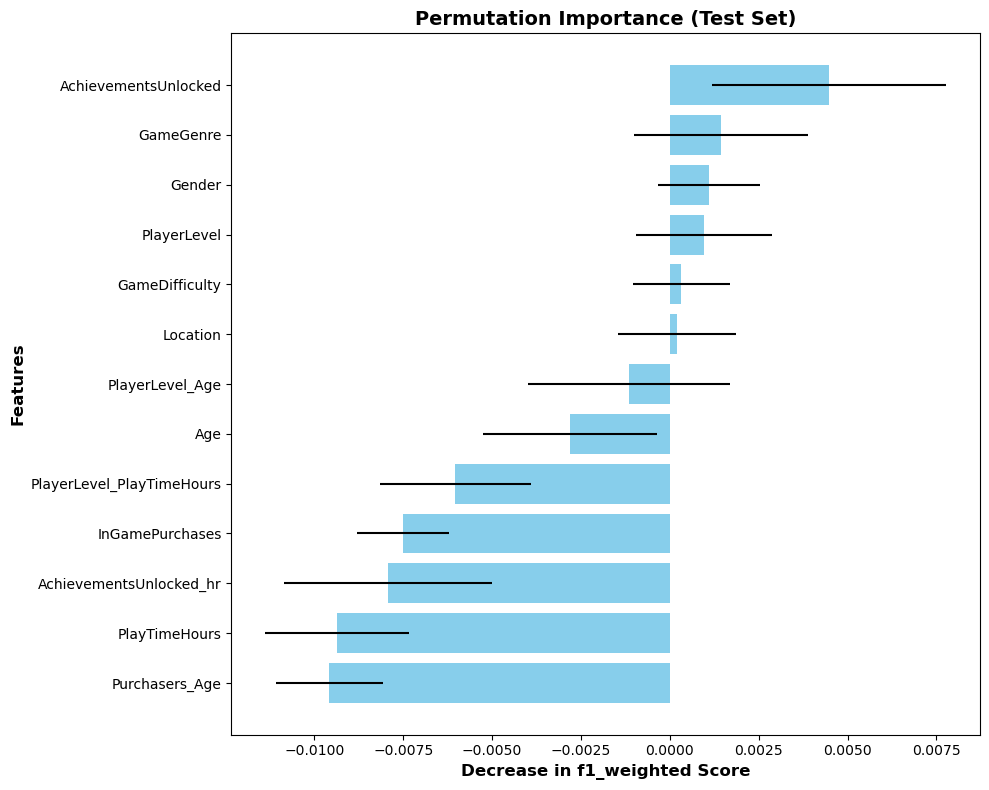

ERROR:root:Pipeline does not contain a 'LR' step. Cannot plot coefficients.
INFO:root:----------------------------------------
INFO:root:Performance Metrics (Average: weighted)
INFO:root:----------------------------------------
INFO:root:AUROC (Area Under ROC Curve): 0.5262
INFO:root:Precision: 0.3835
INFO:root:Recall: 0.4450
INFO:root:F1 Score: 0.3738
INFO:root:----------------------------------------


--- Gradient Boosting Classifier Performance ---


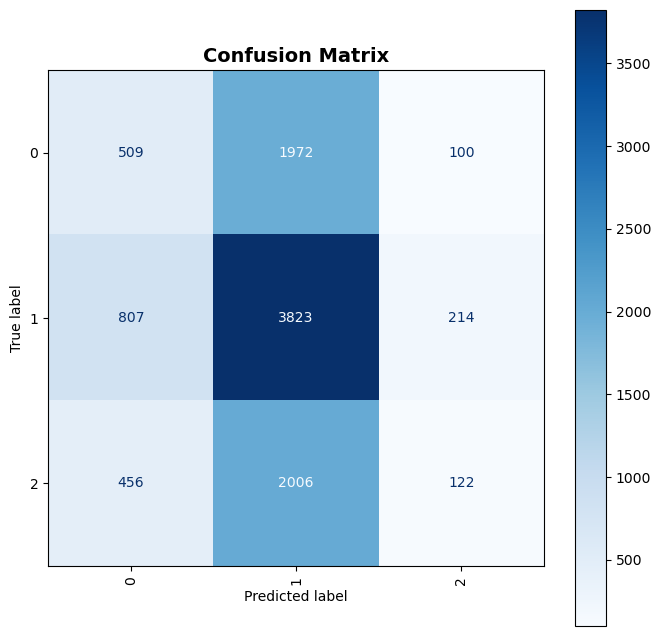

In [149]:
# GBC

# load the artifacts and run QA
artifact_path = 'Exp004_20251031_105937_artifact.pkl'
qa_gbc = ModelQA(artifact_path=artifact_path, 
                #X=X, y=y_true, ID=preprocessed_data['PlayerID']
                )

# Run your plots instantly without retraining!
qa_gbc.plot_permutation_importance()
qa_gbc.plot_model_coefficients() # should convert the log odds impact back to odds ratio scale by exponentiating it (math.exp(x))

print("--- Gradient Boosting Classifier Performance ---")
lr_metrics = qa_gbc.evaluate_model_performance() # You can adjust the threshold

In [ ]:
# It is not clear from the website how or when EngagementLevel is defined, but these features seem to be the outcome of engagement 
# rather than drivers of engagement: 'SessionsPerWeek','Global_Duration','AvgSessionDurationMinutes'

INFO:root:Calculating Permutation Importance using scoring='f1_weighted'...


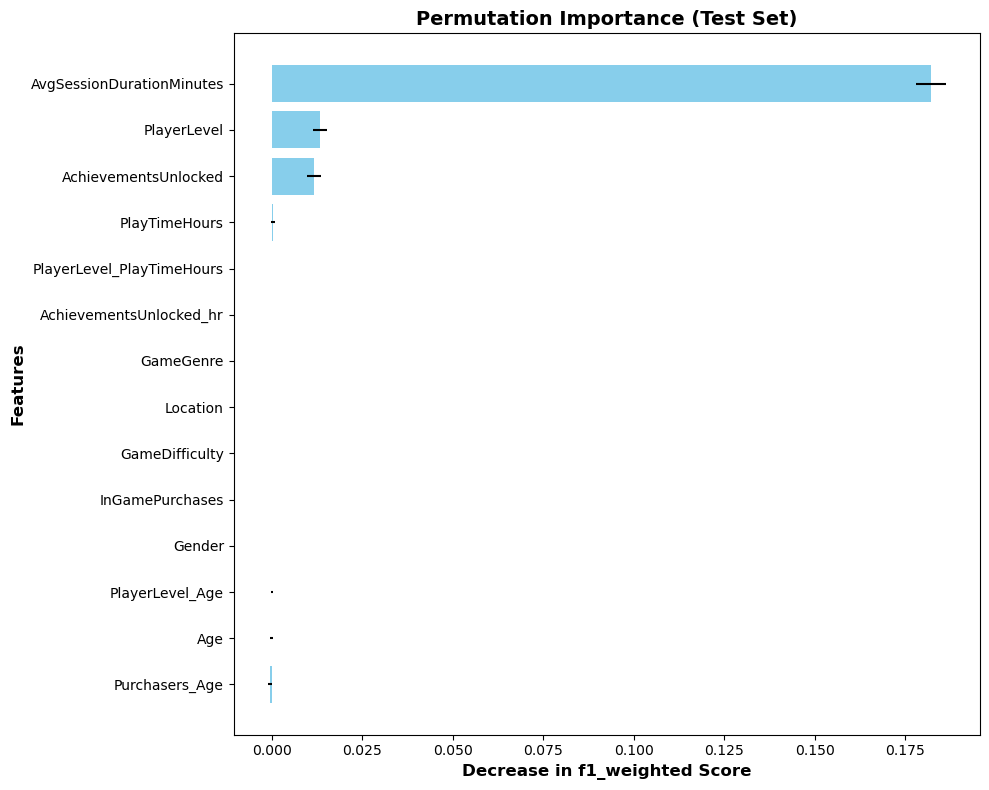

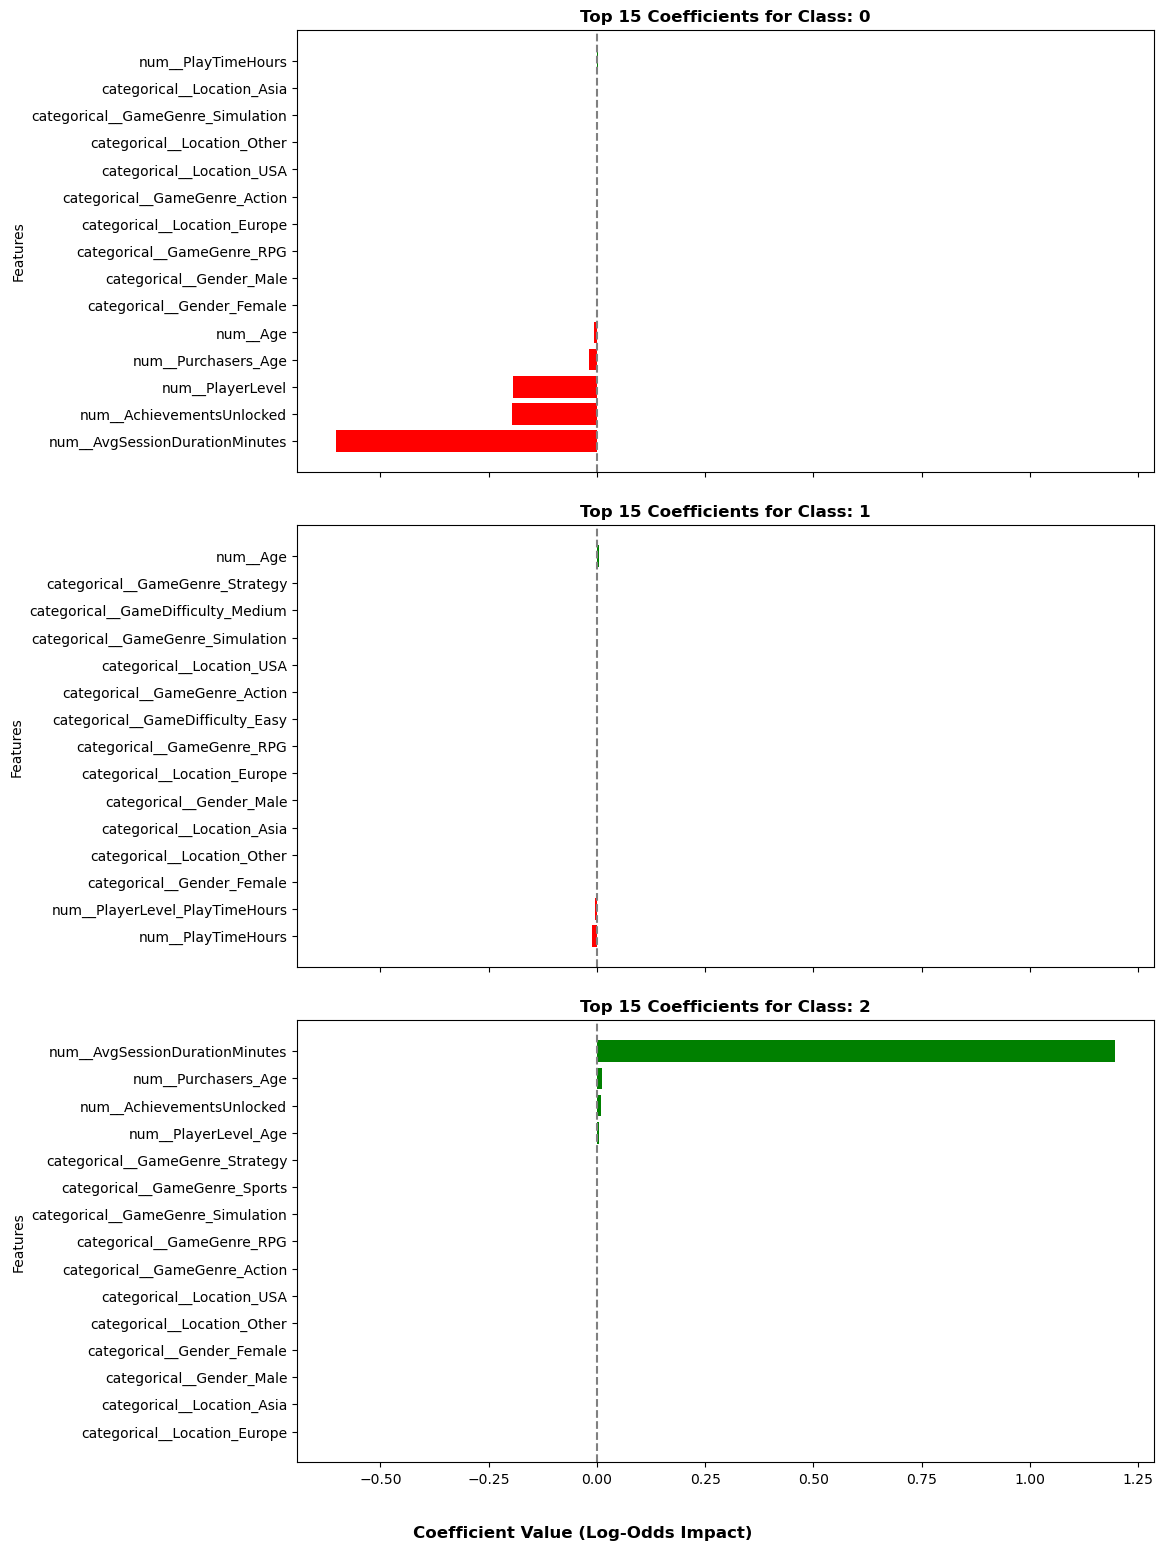

INFO:root:----------------------------------------
INFO:root:Performance Metrics (Average: weighted)
INFO:root:----------------------------------------
INFO:root:AUROC (Area Under ROC Curve): 0.7030
INFO:root:Precision: 0.5711
INFO:root:Recall: 0.5646
INFO:root:F1 Score: 0.5601
INFO:root:----------------------------------------


--- Logistic Regression Performance ---


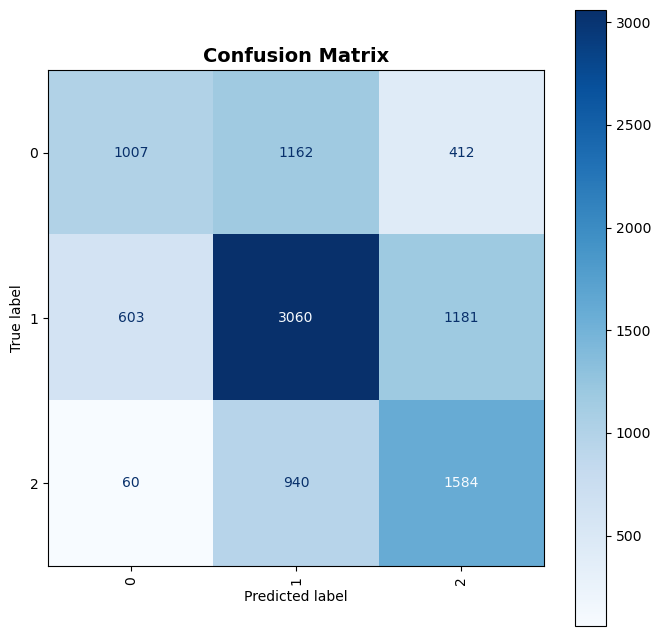

In [142]:
# LR

# load the artifacts and run QA
artifact_path = 'Exp002_20251031_102600_artifact.pkl'
qa_lr = ModelQA(artifact_path=artifact_path, 
                #X=X, y=y_true, ID=preprocessed_data['PlayerID']
                )

# Run your plots instantly without retraining!
qa_lr.plot_permutation_importance()
qa_lr.plot_model_coefficients() # should convert the log odds impact back to odds ratio scale by exponentiating it (math.exp(x))

print("--- Logistic Regression Performance ---")
lr_metrics = qa_lr.evaluate_model_performance() # You can adjust the threshold

INFO:root:Calculating Permutation Importance using scoring='f1_weighted'...


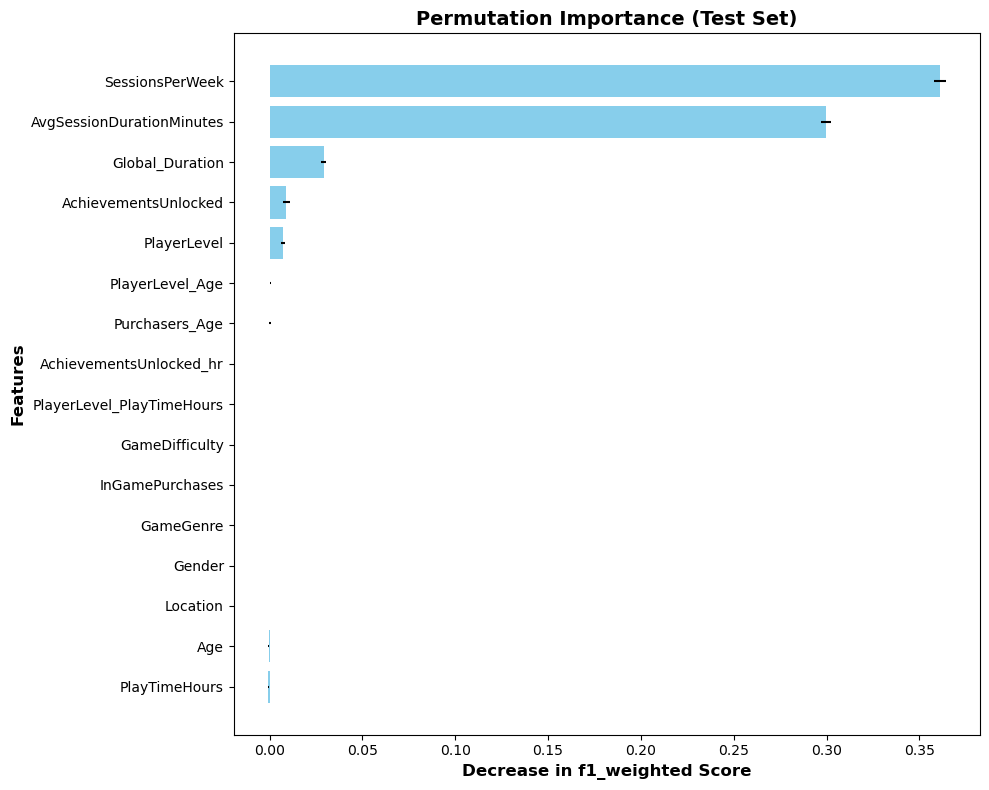

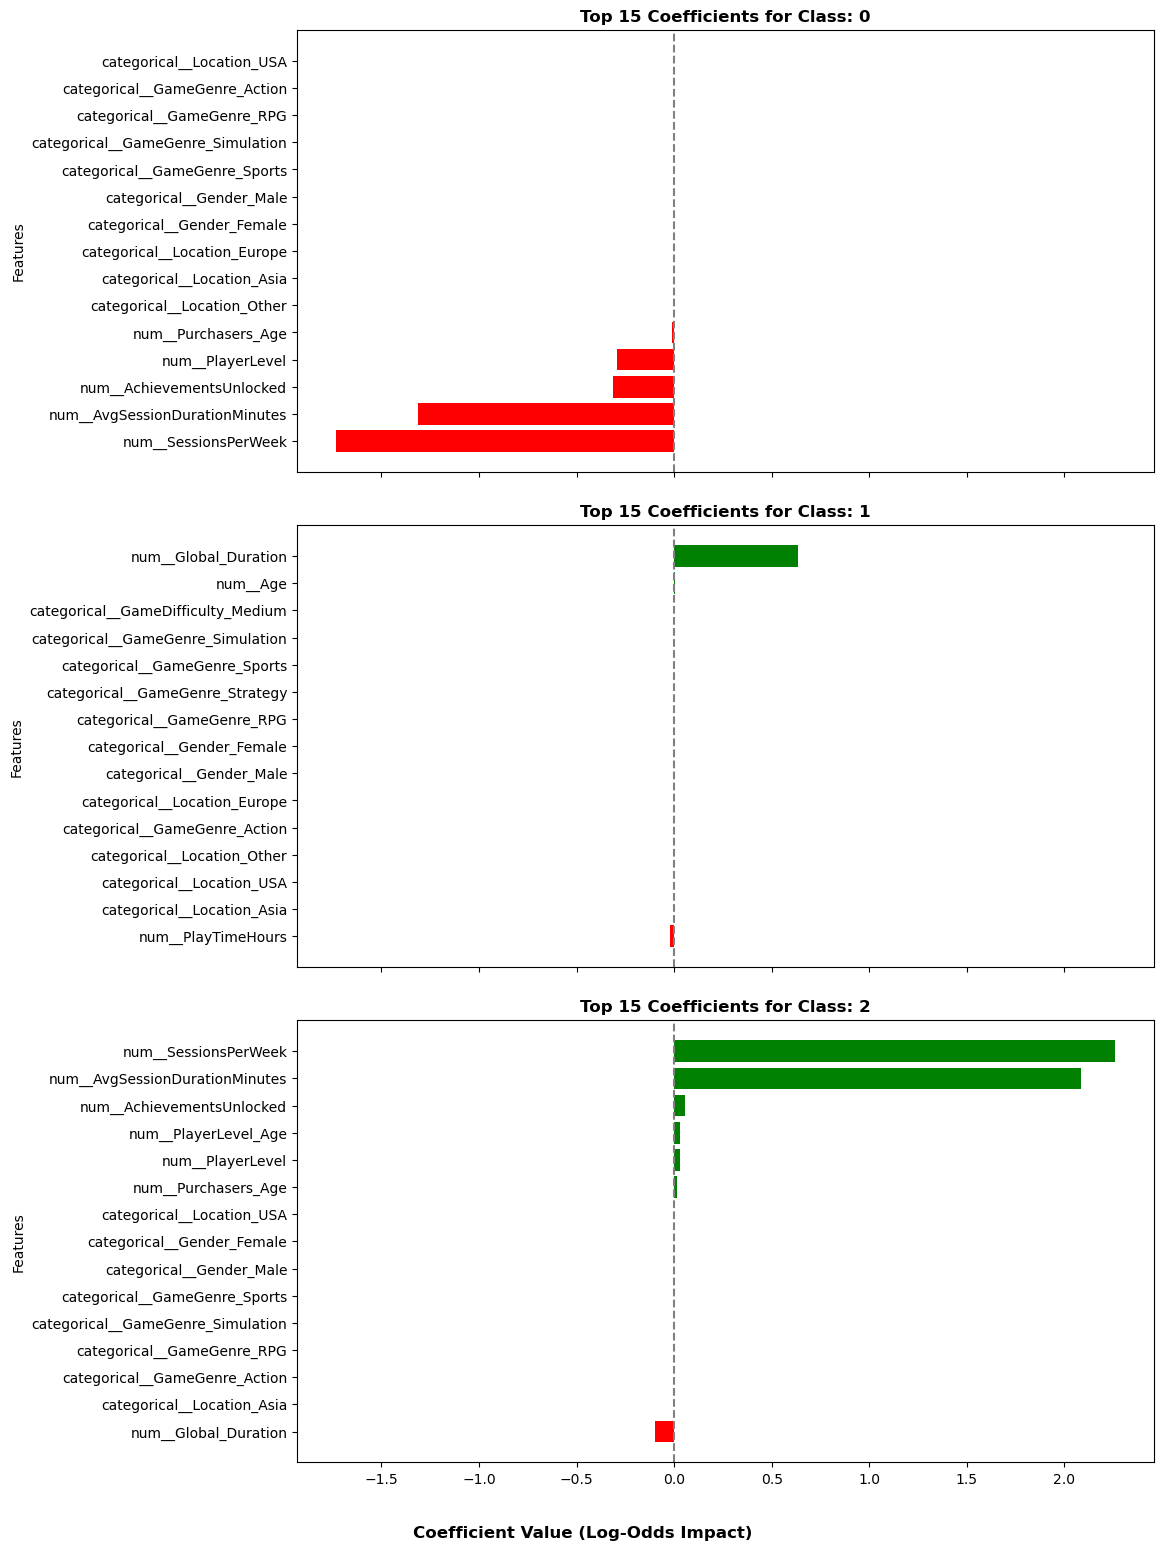

INFO:root:----------------------------------------
INFO:root:Performance Metrics (Average: weighted)
INFO:root:----------------------------------------
INFO:root:AUROC (Area Under ROC Curve): 0.9176
INFO:root:Precision: 0.8364
INFO:root:Recall: 0.8368
INFO:root:F1 Score: 0.8359
INFO:root:----------------------------------------


--- Logistic Regression Performance ---


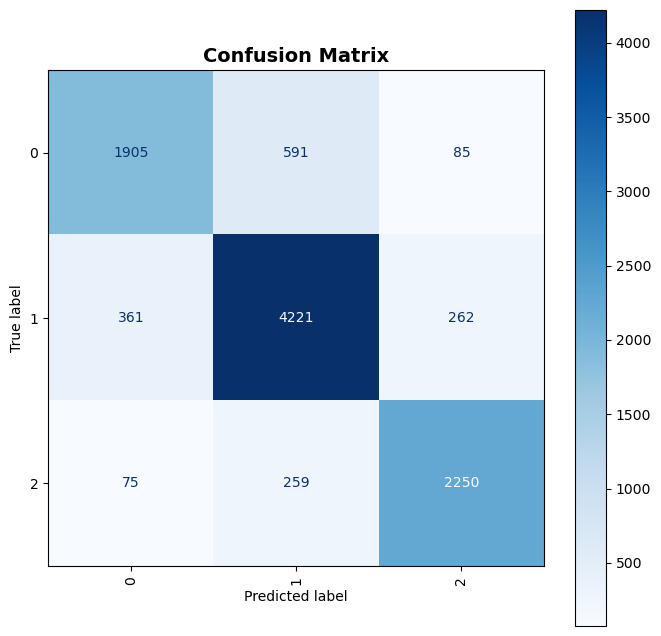

In [135]:
# LR

# load the artifacts and run QA
artifact_path = 'Exp001_20251031_084537_artifact.pkl'
qa_lr = ModelQA(artifact_path=artifact_path, 
                #X=X, y=y_true, ID=preprocessed_data['PlayerID']
                )

# Run your plots instantly without retraining!
qa_lr.plot_permutation_importance()
qa_lr.plot_model_coefficients() # should convert the log odds impact back to odds ratio scale by exponentiating it (math.exp(x))

print("--- Logistic Regression Performance ---")
lr_metrics = qa_lr.evaluate_model_performance() # You can adjust the threshold